In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os, os.path
import sys
sys.path.insert(0,'../processing/')
sys.path.insert(0,'../')
from datasets import sythtextprovider
from nets import txtbox_300, textbox_common, np_methods, txtbox512
#from processing import image_processing
from image_processing2 import *
from processing import ssd_vgg_preprocessing, visualization,txt_preprocessing
import tf_utils
import time
slim = tf.contrib.slim
import load_batch
import numpy as np
import skimage.io as skio
from processing import tf_image
import cv2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
isess = tf.InteractiveSession()

In [5]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    #print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

In [107]:
anchor_sizes=[(30., 60.),
          (60., 114.),
          (114., 168.),
          (168., 222.),
          (222., 276.),
          (276., 330.)]
anchor_sizes=[(21., 51.),
              (51., 99.),
              (133., 153.),
              (215., 207.),
              (296., 261.),
              (379., 315.),
              (461, 543.)]
scale_range=[0.05, 0.75]
scale_range_max = [0.1, 0.9]
scales = [scale_range[0] + i*(scale_range[1] - scale_range[0])/6  for i in range(7)]
scales_max = [scale_range_max[0] + i*(scale_range_max[1] - scale_range_max[0])/6  for i in range(7)]
anchor_sizes = [(512*scales[i], 512*scales_max[i]) for i in range(7)]
anchor_sizes=[(25., 51.),
              (51., 99.),
              (110., 153.),
              (180., 207.),
              (270., 261.),
              (379., 315.),
              (461, 543)]
anchor_sizes


[(25.0, 51.0),
 (51.0, 99.0),
 (110.0, 153.0),
 (180.0, 207.0),
 (270.0, 261.0),
 (379.0, 315.0),
 (461, 543)]

text_shape (512, 512)
0.5
file_path: ../data/ICDAR2013/*.tfrecord


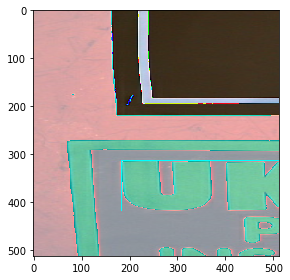

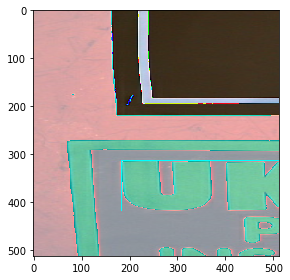

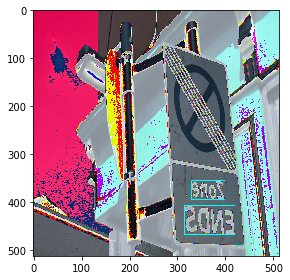

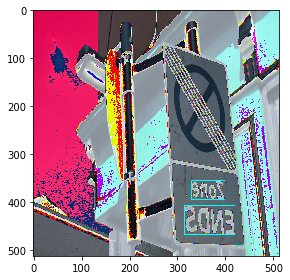

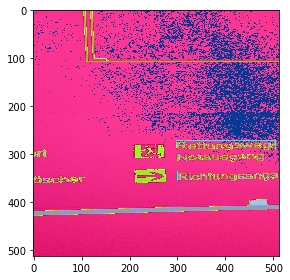

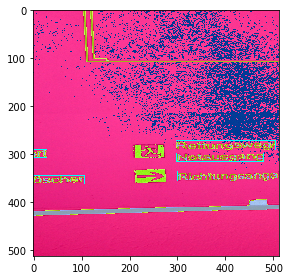

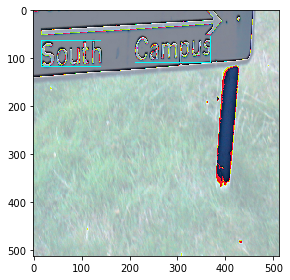

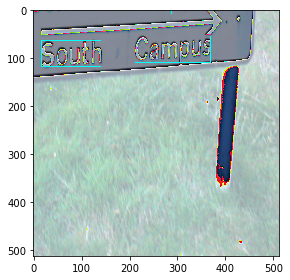

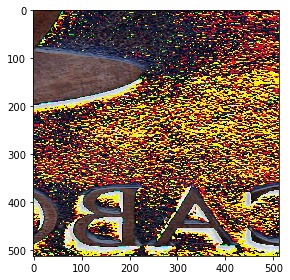

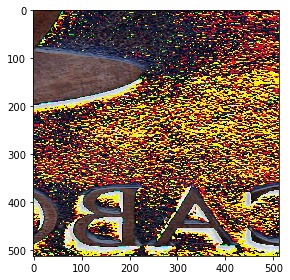

5
78
0.0641025641026


In [109]:
with tf.Graph().as_default(): 
    # build a net\
    params = txtbox512.TextboxNet.default_params
    params = params._replace(anchor_sizes = anchor_sizes)
    text_net = txtbox512.TextboxNet(params)
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/ICDAR2013/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    
    dst_image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                            text_shape,is_training=True)
    
    #image = (dst_image - tf.reduce_min(dst_image))/ (tf.reduce_max(dst_image) - tf.reduce_min(dst_image))
    glocalisations, gscores = \
    text_net.bboxes_encode( gbboxes, text_anchors, num)
    for i in range(6):
        glocalisations[i] = tf.expand_dims(glocalisations[i], axis=0)
        gscores[i] = tf.expand_dims(gscores[i], axis=0)
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            error = []
            box = []
            for i in xrange(5):
                rpredictions, rlocalisations, img ,gbboxes_= sess.run([gscores, glocalisations,dst_image,gbboxes])
                rpredictions_2 = list(rpredictions)
                localb = []
                for i in range(6):
                    decodeb = np_methods.ssd_bboxes_decode(rlocalisations[i],text_anchors[i])
                    localb.append(decodeb[np.where(rpredictions[i] > 0.5)])
                    pre2 = np.expand_dims(1-rpredictions[i], -1)
                    rpredictions[i] = np.concatenate([pre2, np.expand_dims(rpredictions[i], -1)],axis = -1)
                rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
                        rpredictions, rlocalisations, text_anchors,
                        select_threshold=0.001, img_shape=text_shape, num_classes=2, decode=True)

                rbboxes = np_methods.bboxes_clip(rbboxes)
                rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=-1)
                rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, 
                                                                  nms_threshold=0.45)
                #Resize bboxes to original image shape. Note: useless for Resize.WARP!
                bboxes = np.concatenate(localb, 0)
                
                img = img * 255
                image_ = img.astype(np.uint8)
                img_ = image_.copy()
                visualize_bbox(img_, rbboxes)
                
                img = image_.copy()
                #visualize_bbox(img, bboxes)
                img_ = image_.copy()
                visualize_bbox(img_, gbboxes_)
                
                img = image_.copy()

                
                for i in range(6):
                    #pass
                    box.append(gbboxes_.shape[0])
                #error.append((gbboxes_.shape[0] - rbboxes.shape[0]))
                if bboxes.shape[0] > 0:
                    bboxes_uni = np.vstack({tuple(row) for row in bboxes})
                else:
                    bboxes_uni = np.array([])
                error.append((gbboxes_.shape[0] - rbboxes.shape[0]))
                #error.append((gbboxes_.shape[0] - rbboxes.shape[0]))
            print sum(error)
            print sum(box)
            print sum(error)*1.0/sum(box)

In [82]:
(text_anchors[1][0] - text_anchors[1][3]).shape

(32, 32, 2, 7)

In [7]:
gbboxes_

array([[ 0.34278956,  0.13438743,  0.52482271,  1.36363626]], dtype=float32)

In [12]:
with tf.Graph().as_default(): 
    # build a net\
    params = txtbox_300.TextboxNet.default_params
    #params = params._replace(anchor_sizes = anchor_sizes)
    text_net = txtbox_300.TextboxNet(params)
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    print text_net.params.match_threshold
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/ICDAR2013/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    
    dst_image, glabels, gbboxes,num = \
    txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                            text_shape,is_training=True)
    

    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            box = []
            for i in xrange(5000):
                gbboxes_= sess.run([gbboxes])
                leng = gbboxes_[0][:,2] - gbboxes_[0][:,0]
                box.append(leng)


text_shape (300, 300)
0.5
file_path: ../data/ICDAR2013/*.tfrecord


In [15]:
boxes = [i.tolist() for i in box]

In [19]:
all_box = []
combined = [item*300 for sublist in boxes for item in sublist]

In [21]:
import numpy 

hist,bins=np.histogram(combined,bins=np.linspace(0,300,60))
print(hist,bins)

(array([ 257, 1329, 1679, 1427, 1251, 1216, 1004,  917,  792,  638,  460,
        464,  373,  360,  318,  218,  193,  184,  174,  127,  126,  104,
        106,   93,   71,   76,   38,   53,   61,   53,   39,   27,   27,
         26,   17,   30,   29,    9,   20,   15,   13,   18,   12,   10,
         14,   11,    5,   13,   14,    8,    8,    5,    9,    9,    3,
          7,    3,    6,    8]), array([   0.        ,    5.08474576,   10.16949153,   15.25423729,
         20.33898305,   25.42372881,   30.50847458,   35.59322034,
         40.6779661 ,   45.76271186,   50.84745763,   55.93220339,
         61.01694915,   66.10169492,   71.18644068,   76.27118644,
         81.3559322 ,   86.44067797,   91.52542373,   96.61016949,
        101.69491525,  106.77966102,  111.86440678,  116.94915254,
        122.03389831,  127.11864407,  132.20338983,  137.28813559,
        142.37288136,  147.45762712,  152.54237288,  157.62711864,
        162.71186441,  167.79661017,  172.88135593,  177.96610169

In [ ]:
for i in range(6):
    print rlocalisations[i][np.where(rpredictions_2[i] > 0.5)].shape

In [11]:
gbboxes_[0].shape

(5, 4)

In [ ]:
import math
min_dim = 300
min_ratio = 20
max_ratio = 95
step = int(math.floor((max_ratio - min_ratio) / (6 - 2)))
min_sizes = []
max_sizes = []
for ratio in xrange(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 10 / 100.] + min_sizes
max_sizes = [[]] + max_sizes

In [ ]:
np.savetxt(fname='result.csv',X=a,delimiter=',',fmt='%.4f')

In [ ]:
max_sizes

In [ ]:
anchor_sizes